## A model for activation-based sequence replay in a neural network

The goal of this project is to explore an activation-based model (i.e., with no synaptic plasticity) for how a neural network could remember and recall an activity pattern after only "experiencing" it a single time. Replay of this sort is highly relevant to one-shot learning, i.e., learning representations after only a single training trial.

To implement this network I am using a rate-based model in which each unit (e.g., population of neurons) is governed by the following equations:

$\tau_i\cfrac{dv_i}{dt} = -v + v^i_{rest} + \sum_j W_{ij}r_j(t) + d^i_{drive}(t) + \eta(t)$,

$r_j(t) = \phi(g(v_j(t) - v_{th}))$.

where $\tau_i$ is unit $i$'s integration time, $v^i_{rest}$ is the $i$th unit's resting potential, $W$ is a connection weight matrix, $d^i_{drive}(t)$ is the drive to unit $i$ at time $t$, $\eta(t)$ is Gaussian noise, and $g$ and $v_{th}$ are parameters of the transfer function from voltage $v$ to firing rate $r$, where $\phi$ is the sigmoid function:

$\phi(z) = \cfrac{1}{1 + e^{-z}}$.

Note that $W_{ij}$ is the connection to unit $i$ from unit $j$.

All of this is fairly standard so far.

### Basic architecture

This model is fundamentally based on the idea that the memory of a sequence is stored in long time-scale recurrent activity. It is composed of five different types of units, and each unit type is defined by its timescale, its resting potential, and its connectivity pattern. The five types of units are:

* "Fast" excitatory unit - one of the units involved in sequence (both in original presentation and in the replay)
* Inhibitory unit - provides uniform inhibition to fast units (only one inhibitory unit in network)
* "Switch" unit - provides global excitation necessary for  fast units to become spontaneously active
* Slow units (these comprise two subtypes):
  * Memory unit - unit whose activation encodes  recent sequential/simultaneous activation of a particular pair of fast units (there is one memory unit for each distinct pair of fast units)
  * Conduit unit - allows unidirectional communication from one fast unit to another; however, only if also receiving input from a memory unit connected to those two fast units
  
The general idea behind this architecture is that the fast units and inhibitory unit form a spontaneously active winner-take-all network, and the slow units act as mock synapses, enhancing connections between arbitrary pairs of fast units upon recent activation.

### Current progress: activation-based recall of associative memories in semi-spontaneously active WTA network

In the following example, I demonstrate the ability of a network with the above architecture to remember an association and recall it. Specifically, externally driving the red and black fast units sequentially causes the network to remember the red-black association. Then, during spontaneous activity, which is turned on about half-way through the trial (via activation of the switch unit), driving the red unit causes the black unit to respond and driving the black unit causes the red unit to respond, even though $W$ has not been altered.

In [8]:
%matplotlib inline
from figures import wta_memory_combo_basic

### Parameters for neurons, connections, noise, external drive, visualization

In [92]:
CONFIG = {
    'SEED': None,
    
    # unit parameters
    'TAU': 3,  # default integration timescale
    'TAU_M': 25,  # integration timescale of memory units
    'TAU_C': 15,  # integration timescale of conduit units
    'V_TH': 4,  # voltage threshold in firing rate relation
    'STEEPNESS': 2.5,  # steepness of rate/voltage relation
    'V_REST': 0,  # default resting voltage
    'V_REST_C': -10,  # resting voltage for conduit units (note: this could also be implemented via tonic inhibition)
    
    # weight matrix parameters
    'W_IF': 8,  # to inhibitory from "fast"
    'W_FS': 2.5,  # to fast from "switch"
    'W_FI': -6.5,  # to fast from inhibitory
    'W_FF': 8.,  # fast self-excitation
    'W_FC': 5.5,  # to fast from conduit
    'W_MF': 7,  # to memory from fast
    'W_MM': 6.5,  # memory self-excitation
    'W_CF': 9,  # to conduit from fast
    'W_CM': 10,  # to conduit from memory

    'N_UNITS': 6,  # number of fast units (these are the ones in which the memory is exhibited)
    
    'NOISE_LEVEL': 1,  # std of gaussian noise added to all units' voltage
    'S_DRIVE_AMP': 10,  # drive to switching unit
    'F1_DRIVE_AMP': 15,  # drive to fast unit 1 (red)
    'F0_DRIVE_AMP': 15,  # drive to fast unit 0 (black)
    
    'T_F1_DRIVE': 50,  # first start time of fast unit 1 drive (first red)
    'D_F1_DRIVE': 10,  # first duration of fast unit 1 drive
    'T_F0_DRIVE': 75,  # first start time of fast unit 0 drive (first black)
    'D_F0_DRIVE': 10,  # first duration of fast unit 0 drive
    'T2_F1_DRIVE': 250,  # second start time of fast unit 1 drive (second red)
    'D2_F1_DRIVE': 6,  # second duration of fast unit 1 drive
    'T2_F0_DRIVE': 350,  # second start time of fast unit 0 drive (second black)
    'D2_F0_DRIVE': 6,  # second duration of fast unit 0 drive
    'T_S_DRIVE': 150,  # start time of switch drive (which moves the network into its spontaneously active mode)
    'DURATION': 500,  # total simulation time
    
    'FONT_SIZE': 20,
    'COLOR_CYCLE': [
             [0, 0, 0],  # black
             [1, 0, 0],  # red
             [0, 1, 0],  # green
             [0, 0, 1],  # blue
             [1, 1, 0],  # yellow
             [1, 0, 1],  # magenta
             [0, 1, 1],  # cyan
             [.5, 0, 0],  # dark red
             [0, .5, 0],  # dark green
             [0, 0, .5],  # dark blue
        ],
}

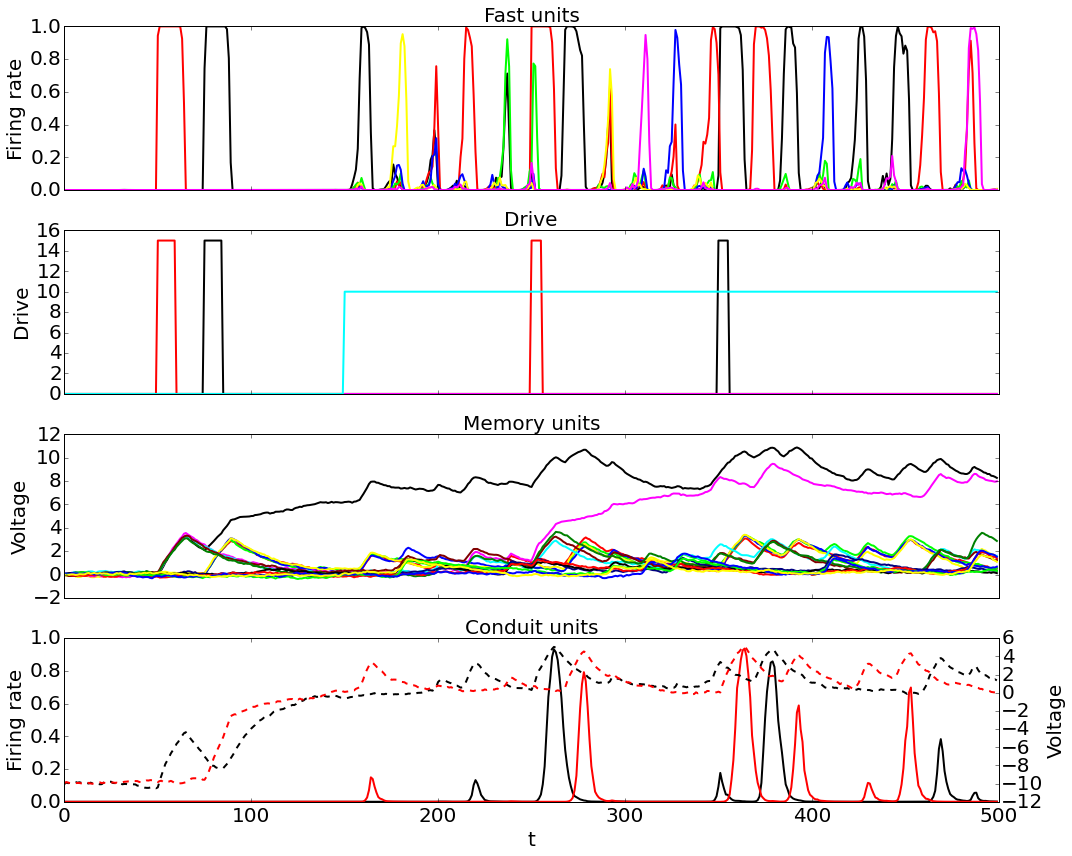

In [101]:
wta_memory_combo_basic.main(CONFIG)

### Figure explanation

* External inputs shown in 2nd row
  * Red and black = inputs to fast units
  * Cyan = input to switch (comes on at $t=150$)

* Fast unit firing rates shown in 1st row
  * 6 fast units in this example, marked by different colors
  * Red and black fast units follow initial red and black drive
  * Spontaneous activity in fast units starts after switch is activated ($t=150$)
  * Spontaneous activity is fairly random and more or less follows WTA rule: only one fast unit active at a time
    * Of course, this isn't perfect, as occasionally multiple units are active simultaneously for a short while
  * When red unit is driven ($t=250$), black unit subsequently activates
  * When black unit is driven ($t=350$), red unit subsequently activates
  * There is even spontaneous activation of the red-black association around $t=480$
  * **This shows that the network remembers the association between the red and black fast units**

* Memory units shown in 3rd row
  * Red-black memory unit (black trace) enters up-state after sequential activation of red and black fast units
  * This upstate is caused by an excitatory self-connection (representing strong recurrence in the population)
  * Notice that all red-something memory units respond transiently after fast red unit activation, but only red-black memory unit enters up-state, since it is the only one that receives input from red and black fast units

* Conduit units shown in 4th row
  * Only red->black (black trace) and black->red (red trace) conduit units shown
  * After red-black memory unit enters up-state, red->black and black->red conduit units enter up-state also
  * Conduit unit upstate, however, is not caused by self-connection, but rather input from red-black memory unit
  * Conduit units can only cross their threshold (indicated by firing rate being nonzero) when they receive input from memory unit
    * After red-black memory unit is activated, conduit units are activated by fast units enough to start firing
    * E.g., when red fast unit is driven at $t=250$, red->black conduit unit activates, subsequently activating black fast unit

* **Thus: red-black memory unit + red->black and black->red conduit units form "mock synapse" between red and black fast units**
* **This forms an effective communication channel between red and black fast units that is opened by their previous activations**
* **The memory unit's activity is biophysically relevant to PFC activity, in which persistent activity has frequently been seen to correlate with working memory**

## Other things of note

### Spontaneous activity arises from pseudo-bistable states in fast units

Each fast unit has an excitatory self-connection, $W_{FF}$. Thus, the dynamical system for a fast unit $i$ with constant external input $d$ is given by:

$\dot v_i = f(v_i) = \cfrac{1}{\tau_F}\left[-v_i + W_{FF}\phi(g(v_i - v_{th})) + v^0_i + d\right]$.

What does this function look like? 

In [2]:
from figures import single_unit_dynamical_system

In [5]:
CONFIG = {
    'TAU_F': 3,
    'W_FF': 8,
    'V_TH': 4,
    'G': 2.5,
    'V_0': 0,
    'DS': range(-3, 4),
    
    'FONT_SIZE': 20,
    'FIG_SIZE': (10, 7),
}

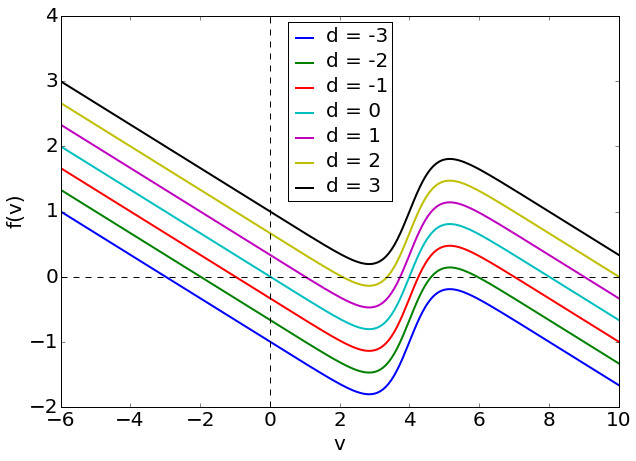

In [6]:
single_unit_dynamical_system.main(CONFIG)

From these plots we see that $f(v)$ has either $1$ or $2$ stable fixed points (zero-crossings with negative slope), depending on the drive $d$. The fast unit has $1$ fixed point when $d$ is high or low and so will always settle to either an "up" or a "down" state, respectively. When $d$ takes an intermediate value, however, the system can rest stably in either the high or low state. 

The interesting cases are when $d$ is near a bifurcation point, i.e., in the green ($d = -2$) and yellow ($d = +2$) traces. In the green case, for example, the up-state is technically stable, but barely so. Specifically, a relatively small amount of noise can knock the fast unit out of the up-state and into the down-state. I.e., because of noise the fast unit can make the up->down transition with ease. It cannot make the down->up transition easily, however. In the yellow trace, the reverse is true. The fast unit can easily make the down->up transition, but will make never make the up->down transition.

### Spontaneous switching

* So how can a fast unit transition spontaneously between both up- and down-states? 
* Can occur if drive $d$ changes in response to its activation state
  * Want $d(\textrm{down-state}) > 0$, $d(\textrm{up-state}) < 0$
* Biophysically motivated implementation:
  * Fast units receive uniform baseline drive (e.g., $d=2$) always
  * Fast units receive additional inhibitory drive (e.g., $d=2 - 4 = -2$) when in up-state
  * Consistent with fast units projecting onto inhibitory units, which project back onto fast units
    * E.g., fast in down-state -> inhibitory inactive, fast in up-state -> inhibitory active
* This leads to fast units spontaneously switching between up- and down-states, each one being pseudo-stable
  * Stability/time in up-/down-state depends on strength of drive, self-connection, noise level

### Winner-take-all behavior

* Interestingly, above can be implemented with only single inhibitory unit:
  * Receives equal projections from all fast units
  * Sends equal projections to all fast units
* Plays dual role of silencing other fast units and making active fast unit's up-state "pseudo-unstable"

## Model short-comings

#### Non-specific activation of memory units

Not shown in above example, but memory unit A-B can be activated by A and B firing in a small temporal window, or by A (or B) firing for a longer time individually. For instance, if A fires for a long time, this will activate, all memory units connected to A (A-B, A-C, A-D, ...). This makes irrelevant the identity of the fast unit that fires subsequently, so the network cannot remember an association.

One way of fixing this is to add a mechanism that forces some kind of stereotypy upon the fast unit activations, regardless of whether it was activated by external drive, conduit input, or spontaneously. This could be done through single unit or network adaptation (through another inhibitory unit, for instance) and would take away the dependence of behavior on small changes in activity time-scales.

Another possible way of fixing this is to add a mechanism such that what is remembered by the network are not only transitions, but individual activations as well. E.g., each fast unit could have its own individual memory unit that entered an up-state upon activation of the fast unit. This might allow the network to also show some kind of short-term recognition memory.

#### Lack of replay of sequences

The model cannot yet do this, since the activation of the second unit in an association (e.g., the black unit at $t=270$) is weaker than the activation of the first. Thus, the sequence would decay away very quickly and no more than 2 or 3 items could be remembered. However, this could also be fixed by enforcing the activation of fast units to have a stereotyped time-course, so that one could get "lossless" propagation of a sequence.

A problem with "lossless" sequence propagation through stereotyped fast unit activation, however, is that one might get "pathological" oscillations, i.e., the memory of an association between fast units A and B would get replayed not just as AB or BA but as ABABABABAB... One way of preventing this is to let a fast unit be inhibited for a few time-steps after its activation, such that it could not respond quickly enough for a pathological oscillation to develop.

#### Potentially unreasonable number of memory units are required

The number of memory units required to remember sequences among $n$ fast units is $\sim O(n^2)$. This could be unreasonable, as it hypothesizes already present connections among all possible units capable of being replayed in a sequence. One way of relaxing this large number of memory units, however, is to assume that one memory unit might actually be activated by (and allow conduit-based communication) among multiple fast units, and that the fast units that are to be replayed are somehow distinguished from the others by an activation-based marker (e.g., something projecting to them moves to an up-state).